# Classifying Tweets

In this project, I go through the steps of importing data, performing exploratory data analysis, data cleaning, training a binary classifier, and evaluating the model.

# Data


<p>This dataset included 10,876 tweets human-tagged as Relevant or Not Relevant. Tweets labeled as "Relevant" were about disasters, tweet about miscellaneous topics were tagged as "Not Relevant", and some tweets were tagged as "Can't Decide" when topic could not be determined.</p>

**Features**
- _unit_id
- _golden
- _trusted_judgments
- _last_judgment_at
- choose_one (used as label)
- choose_one_confidence
- choose_one_gold
- keyword
- location
- text: (used as data)
- tweetid
- userid

In [1]:
from nltk.tokenize.casual import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
from sklearn.metrics import f1_score,roc_curve, confusion_matrix, auc
from nltk.stem.snowball import SnowballStemmer

import pandas as pd
import numpy as np
import re
import enchant #From PyEnchant
import matplotlib.pyplot as plt
%matplotlib inline

# Let's take a look at the data

In [2]:
#Read in data using pandas
twitter =  pd.read_csv('../Final_Project_1/Final_Project_1/data/disaster-tweets-DFE.csv')

#Display first 5 entries
twitter.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid
0,778243823,True,golden,156,NaN,Relevant,1.0000,Relevant,NaN,NaN,Just happened a terrible car crash,1,NaN
1,778243824,True,golden,152,NaN,Relevant,1.0000,Relevant,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,13,NaN
2,778243825,True,golden,137,NaN,Relevant,1.0000,Relevant,NaN,NaN,"Heard about #earthquake is different cities, s...",14,NaN
3,778243826,True,golden,136,NaN,Relevant,0.9603,Relevant,NaN,NaN,"there is a forest fire at spot pond, geese are...",15,NaN
4,778243827,True,golden,138,NaN,Relevant,1.0000,Relevant,NaN,NaN,Forest fire near La Ronge Sask. Canada,16,NaN


#### Look at a summary of the features

In [3]:
twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10876 entries, 0 to 10875
Data columns (total 13 columns):
_unit_id                 10876 non-null int64
_golden                  10876 non-null bool
_unit_state              10876 non-null object
_trusted_judgments       10876 non-null int64
_last_judgment_at        10792 non-null object
choose_one               10876 non-null object
choose_one:confidence    10876 non-null float64
choose_one_gold          87 non-null object
keyword                  10789 non-null object
location                 7238 non-null object
text                     10876 non-null object
tweetid                  10876 non-null int64
userid                   10789 non-null float64
dtypes: bool(1), float64(2), int64(3), object(7)
memory usage: 1.1+ MB


#### For this project I am only interested in the actual tweets and whether they are tagged as relevant or not relevant.

In [4]:
#Look at the first entry in the text column of twitter dataframe
print twitter['text'][0]
print "----------"
print twitter['choose_one'][0]

# This tweet has been labeled as being about a disaster

Just happened a terrible car crash
----------
Relevant


In [5]:
#Look at another entry in the text column of twitter dataframe
print twitter['text'][10789]
print "----------"
print twitter['choose_one'][10789]

# This tweet has been labeled as not being about a disaster

Four hundred wrecked cars (costing $100 apiece) were purchased for the making of this 1986 film - http://t.co/DTdidinQyF
----------
Not Relevant


<h3>Let's take a look at the labels</h3>

<h4>First we need to import matplotlib to plot the data<h/4>

In [6]:
twitter['choose_one'].value_counts()

Not Relevant    6187
Relevant        4673
Can't Decide      16
dtype: int64

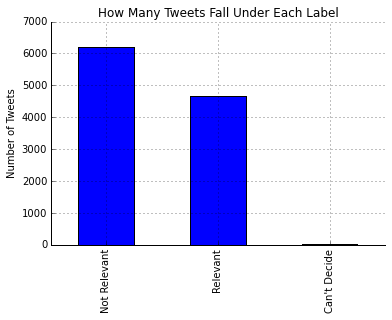

In [7]:
label_count = twitter['choose_one'].value_counts().plot(kind='bar');

# Hide the right and top spines
label_count.spines['right'].set_visible(False)
label_count.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
label_count.yaxis.set_ticks_position('left')
label_count.xaxis.set_ticks_position('bottom')

#Create labels
plt.ylabel('Number of Tweets')
plt.title('How Many Tweets Fall Under Each Label');

## Extract Data

<p>The classes or labels are balanced with the exception of the "Can't Decide" class. This can skew the results of the classifier by overfitting on these few examples of "Can't Decide". Plus we want to predict whether or not a tweet is talking about a disaster, so ambiguous tweets are not helpful. In the next step I will remove all tweets labeled as "Can't Decide".</p>

In [8]:
#If the choose_one column is not equal to "Can't Decide" copy the entire row over to the new dataframe - twitter_clean
twitter_clean = twitter[twitter['choose_one'] != "Can't Decide"]

<p>The classifier we will be using does not work with text. Therefore in the next few steps we will be preparing the data for the classifier. The first step is the binarize the labels.</p>

In [9]:
#Extract labels and data and put in numpy array

#Binarize data --> Relevant = 1, Not Relevant = 0
y = np.asarray(twitter_clean['choose_one'].apply(lambda x: 1 if x == 'Relevant' else 0))

#Enter tweets into numpy array "as is". We must do some data cleaning before binarizing the tweets.
tweets = np.asarray(twitter_clean['text'])

In [10]:
print tweets[0]
print y[0] # 1 for Relevant

Just happened a terrible car crash
1


## Data Cleaning

<p>As we all know, tweets are different from the text we may read in a news article or book. People use hashtags, URLs, creative spellings (e.g. r u sleeping), acronyms (e.g. lol) and they add characters or use all caps for emphasis (e.g. looooool, HELP). In order for our classifier to accurately predict the label of a tweet we must normalize our data. Therefore, "loooool" and "LOL" must become "lol" and "HELP" must become "help". We also need to account for suffixes, so "flooding" and "flooded" need to become "flood". We will do all of this with the help of regular expressions and two libraries: Enchant and NLTK. Enchant provides you with a spell checker and NLTK is one of the most widely used natural language processing libraries.</p>

### Remove URLs

In [11]:
# function to remove URLs
def remove_urls(sentence):
    '''
    input an array of tweets and get two arrays,
    one with tweets without URLs and another with 1's
    and 0's to indicate whether a tweet had a URL before cleaning.
    1 = had URL, 0 = no URL
    '''
    has_url = np.zeros(len(sentence)) #array of zeros
    
    '''iterate thru tweets find variations of url and record
    whether tweet had url. Store tokens that don't begin
    with http. First remove &amp; characters.
    
    '''
    #copy data from sentence to new array
    clean_sent = sentence.copy()
    for i, sent in enumerate(sentence):
        tweets[i] = re.sub('&amp;', '', sent)
        sent_clean = []
        for token in re.findall('(https?:\/\/)?([\da-z\.-\/\dA-z]+)', sentence[i]):
            if token[0] == 'http://':
                has_url[i] = 1
            elif token[0] == 'https://':
                has_url[i] = 1
            elif token[0] == 'https //':
                has_url[i] = 1
            else:
                sent_clean.append(token[0])
                sent_clean.append(token[1])
            #join tokens together to make sentence again
            clean_sent[i] = ' '.join(sent_clean)
    return clean_sent, has_url

In [12]:
tweets_no_url, has_url = remove_urls(tweets)

#### Let's see the before and after of a tweet

In [13]:
#index list backwards
print tweets[-97]
print "------------"
print tweets_no_url[-97]

Wreckage 'Conclusively Confirmed' as From MH370: Malaysia PM: Investigators and the families of those who were... http://t.co/MSsq0sVnBM
------------
 Wreckage  Conclusively  Confirmed  as  From  MH370  Malaysia  PM  Investigators  and  the  families  of  those  who  were...


### Remove duplicate characters

In [14]:
#Function to remove duplicate vowels, e.g gooooal
def remove_duplicates(word_list):
    '''
    input a list of words and get new list of words
    with no duplicate vowels
    '''
    letters = ['a','e','i','o','u']
    d = enchant.Dict("en_US")
    new_list = []
    
    for word in word_list:
        #check if word is spelled correctly and append to list
        if d.check(word):
            new_list.append(word)
        #if word not spelled correctly apply regex
        else:
            for i in xrange(len(letters)):
                word = re.sub(letters[i]+'+', letters[i], word)
            new_list.append(word)
    return new_list

In [15]:
#Twitter tokenizer, removes handles (@), converts characters to lowercase, reduce length
#of duplicate letters. For example, if you have duplicate letters -> gooooal -> goooal
tweet_tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

In [16]:
tweet_tokens = tweets_no_url.copy()

for i, tweet in enumerate(tweets_no_url):
    #iterates through tweets and uses NLTK tweet tokenizer to 
    #tokenize sentences. Also converts all characters to lowercase
    #then passes list of words to function.
    tweet_tokens[i] = remove_duplicates(tweet_tokenizer.tokenize(tweet))

#### Before and after

In [17]:
print tweets_no_url[28]
print "------------"
print tweet_tokens[28]

 What  a  goooooooaaaaaal
------------
[u'what', u'a', u'goal']


### Remove punctuations and suffixes

In [18]:
#Stem word tokens and remove punctuation
snow_stemmer = SnowballStemmer("english")
stemmed_tweets = tweet_tokens.copy()

#Iterate through list of tweets
for i, lst in enumerate(stemmed_tweets):
    new_lst = []
    #Iterate through list of words
    for word in lst:
        #if word is not a punctuation
        #add to new_lst
        if word not in ['.','!','...','?',"'"]:
            new_word = snow_stemmer.stem(word)
            new_lst.append(new_word)
    stemmed_tweets[i] = new_lst

#### Before and after

In [19]:
print tweet_tokens[10]
print "------------"
print stemmed_tweets[10]

#Stemmer isn't perfect, but all words will be in the same format. This will be beneficial for binarizing the tweets.

[u'flood', u'disaster', u'heavy', u'rain', u'causes', u'flash', u'flooding', u'of', u'streets', u'in', u'manitou', u'colorado', u'springs', u'areas']
------------
[u'flood', u'disast', u'heavi', u'rain', u'caus', u'flash', u'flood', u'of', u'street', u'in', u'manitou', u'colorado', u'spring', u'area']


### Binarize the tweets

In [20]:
#Make list of words sentences again for vectorizer

stemmed_list =[]
for lst in stemmed_tweets:
    n_list = ' '.join(lst)
    stemmed_list.append(n_list)

In [21]:
#create CountVectorizer object
#Removes stop words (e.g the, a, and) which are common words with high frequency that contribute no meaning.
#Analyzer determines whether feature will be treated as a word or ngrams
#max_features only keeps top 5000 most frequent features
feat_vectorizer = CountVectorizer(stop_words='english', analyzer='word', max_features=5000)

In [22]:
vectorized_tweets = feat_vectorizer.fit_transform(stemmed_list)

#### Creating the feature matrix

In [23]:
#Concatenate the has_url array with the binarized tweets sparse matrix

#reshape has_url to add to feature vector matrix
has_url = has_url.reshape(-1,1)

#Convert sparse matrix (needed for concatenation) and concatenate to has_url
X = np.concatenate((vectorized_tweets.todense(), has_url), axis=1)

In [24]:
#Get feature names and add has_url to feature names
#This will come in handy when looking at the most important features

feature_names = np.asarray(feat_vectorizer.get_feature_names()).reshape(5000, 1)
feature_names = np.concatenate((feature_names, np.asarray([[u'has_url']])), axis=0)

## Train Our Model
### It's machine learning time!

Before shoving our data into a classifier, we must randomly sample the data into training and test data.
We can do this by using sci-kit learn's train_test_split function.

In [25]:
#Randomly splits data -> default 80% goes to training dataset and 20% to the test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y)

Before we get to predicting labels, let's do a quick sanity check. You can use Random Forest to check
which features have the most predictive power. This step can be consider as exploratory
data analysis.

In [26]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### *Results will vary because data is randomly split into training and test sets

In [27]:
#Check which features (words) are most important
indices_max = rf.feature_importances_.argsort()[-10:][::-1] #return indices for top 10 features
top_feat = feature_names[indices_max.reshape(10,1)] #use indices to pull feature names
print top_feat

[[[u'has_url']]

 [[u'hiroshima']]

 [[u'evacu']]

 [[u'bomb']]

 [[u'polic']]

 [[u'wildfir']]

 [[u'kill']]

 [[u'california']]

 [[u'report']]

 [[u'flood']]]


### Let's predict labels using Logistic Regression

In [28]:
#Fit model
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [29]:
#Predict labels and probabilities
lr_predict = lr.predict(X_test)
lr_predict_prob = lr.predict_proba(X_test) #used for ROC curve

## Evaluate Our Model

In [30]:
#Use cross_validation to sample our data 10 times and test our classifier with the 10 samples
#then take the mean of the accuracy scores.
print 'Accuracy: ', np.mean(cross_validation.cross_val_score(lr, X, y, cv=10))

Accuracy:  0.608863502659


<p>

F1 score tends to be a better metric for model performance because accuracy only take into account the correction predictions. The F1 score takes into account precision and recall. 

<ul>
    <li> Precision is the number true positives (tweets you labeled as relevant that were relevant) divided by the number of true positives and false positives (tweets you labeled as relevant, but were not relevant).</li>
    
    <li> Recall is the number of true positives over the number of true positive and false negatives (tweets you labeled as not relevant, but they were relevant.)</li>
    
</ul>

</p>

In [31]:
print 'F_1_score = ', f1_score(y_test, lr_predict)

F_1_score =  0.757142857143


We can further test our true positive and false positive rates by plotting the ROC curve. The more area under the curve the better the model is performing.

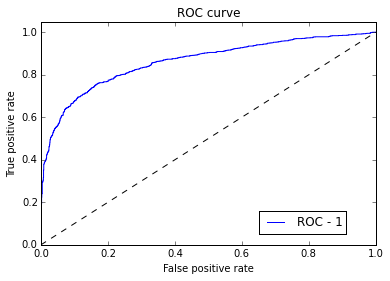

In [32]:
#ROC calculations
fpr, tpr, thresholds = roc_curve(y_test, lr_predict_prob[:,1])

plt.plot(fpr, tpr,label='ROC - 1')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc=[0.65,0.05])
plt.show()

We can also look at the confusion matrix

[[1323  225]
 [ 319  848]]


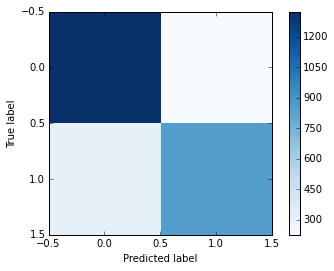

In [33]:
cm = confusion_matrix(y_test, lr_predict)
print cm

#From sklearn example
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues);
plt.colorbar();
plt.ylabel('True label');
plt.xlabel('Predicted label');

###### Although machine learning is the coolest part of data science, your classifier is nothing without good data cleaning and feature engineering. So make sure you spend a lot of time performing EDA, to know how to "massage" your data and get the most out of it.

## Future

You don't have to stop here! You can take this project further and classify tweets in real-time. Then take the tweets about disasters and predict which emergency resources should be dispatched. This type of technology could be handy in natural disasters, by helping emergency responders locate people who need help.